# 2021 Stack Overflow Survey Results analysis


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


## Data Exploration

In [2]:
# read data to dataframe
df_2021 = pd.read_csv('./survey_results_public.csv', encoding = "utf-8")
df_2021_schema = pd.read_csv('./survey_results_schema.csv', encoding = "utf-8")


First, we want to look at our data and understand the shape of it, the list of columns,
and look at some values.

In [3]:
df_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83439 entries, 0 to 83438
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ResponseId                    83439 non-null  int64  
 1   MainBranch                    83439 non-null  object 
 2   Employment                    83323 non-null  object 
 3   Country                       83439 non-null  object 
 4   US_State                      14920 non-null  object 
 5   UK_Country                    4418 non-null   object 
 6   EdLevel                       83126 non-null  object 
 7   Age1stCode                    83243 non-null  object 
 8   LearnCode                     82963 non-null  object 
 9   YearsCode                     81641 non-null  object 
 10  YearsCodePro                  61216 non-null  object 
 11  DevType                       66484 non-null  object 
 12  OrgSize                       60726 non-null  object 
 13  C

In [4]:
df_2021.columns

Index(['ResponseId', 'MainBranch', 'Employment', 'Country', 'US_State',
       'UK_Country', 'EdLevel', 'Age1stCode', 'LearnCode', 'YearsCode',
       'YearsCodePro', 'DevType', 'OrgSize', 'Currency', 'CompTotal',
       'CompFreq', 'LanguageHaveWorkedWith', 'LanguageWantToWorkWith',
       'DatabaseHaveWorkedWith', 'DatabaseWantToWorkWith',
       'PlatformHaveWorkedWith', 'PlatformWantToWorkWith',
       'WebframeHaveWorkedWith', 'WebframeWantToWorkWith',
       'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith',
       'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith',
       'NEWCollabToolsHaveWorkedWith', 'NEWCollabToolsWantToWorkWith', 'OpSys',
       'NEWStuck', 'NEWSOSites', 'SOVisitFreq', 'SOAccount', 'SOPartFreq',
       'SOComm', 'NEWOtherComms', 'Age', 'Gender', 'Trans', 'Sexuality',
       'Ethnicity', 'Accessibility', 'MentalHealth', 'SurveyLength',
       'SurveyEase', 'ConvertedCompYearly'],
      dtype='object')

## Question 1: What are the most popular languages in 2021?

Let's look at the values in the column, containing used languages.

In [5]:
df_2021['LanguageHaveWorkedWith'].value_counts()

Python                                                                   1337
HTML/CSS;JavaScript;Node.js;TypeScript                                    811
Java                                                                      715
HTML/CSS;JavaScript;PHP;SQL                                               674
C#                                                                        597
                                                                         ... 
HTML/CSS;Java;JavaScript;Matlab;Node.js;Python;Rust                         1
C#;JavaScript;Kotlin;Python;SQL;TypeScript;VBA                              1
C;HTML/CSS;Java;JavaScript;Kotlin;Matlab;Node.js;Python;SQL                 1
Assembly;C;C++;Java;Python;R;Rust                                           1
C;C#;C++;HTML/CSS;Java;JavaScript;Node.js;PowerShell;Python;SQL;Swift       1
Name: LanguageHaveWorkedWith, Length: 28690, dtype: int64

We can see, that it was a multiple choice question, and all the values are stored together, separated by semicolon.
In order to analyze this data, we will need to count single languages.

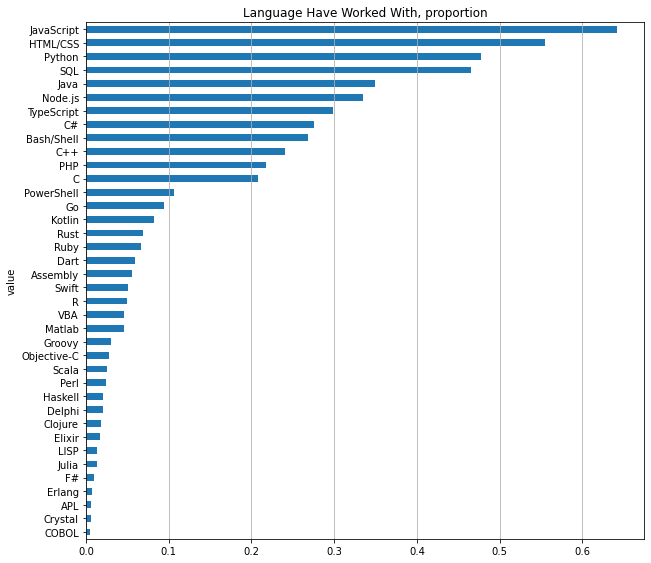

In [9]:
from collections import defaultdict


def get_possible_vals(col):
    '''
    INPUT 
        col - pandas Series, the column with semicolon separated values
    OUTPUT
        Set of single values
    '''

    return(set([val.strip() for sublist in col.dropna().str.split(";").tolist() for val in sublist]))


def get_total_counts(df, col, col_suffix=''):
    '''
    INPUT 
        df - DataFrame, data
        col - string, holding the column name
        col_suffix - string, suffix for the 'count' column in the resulting dataframe
    OUTPUT
        new_df - DataFrame, value counts
    '''

    df_val_counts = df[col].value_counts().reset_index()
    df_val_counts = df_val_counts.rename(columns={'index': 'value', col: 'count'})
    possible_vals = get_possible_vals(df[col])

    new_df = defaultdict(int)
    #loop through the list of possible values
    for val in possible_vals:
        #loop through rows
        for idx in range(df_val_counts.shape[0]):
            row_vals = df_val_counts['value'][idx].split(";")
            if val in row_vals:
                new_df[val] += int(df_val_counts['count'][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = ['value', 'count'+col_suffix]
    return new_df


def clean_and_plot(df, col, col_suffix='', title='', plot=True):
    '''
    INPUT 
        df - DataFrame, data
        col - string, holding the column name
        col_suffix - string, suffix for the 'count' column in the resulting dataframe
        title - string, the title of plot
        plot - bool, whether or not a plot needed
    OUTPUT
        df_prop - DataFrame, proportions of the column values
        Displays a plot for proportions of the column values.
    '''

    df_counts = get_total_counts(df, col, col_suffix)

    df_prop = df_counts.sort_values('count'+col_suffix, ascending=True).set_index('value')
    df_prop = df_prop/df[col].shape[0]
    if plot:
        df_prop.plot(kind='barh',figsize=(10,0.25*len(df_prop)), legend=None).grid(axis='x');
        plt.title(title);
        plt.show()
    return df_prop

df_lang_worked = clean_and_plot(df_2021, col='LanguageHaveWorkedWith', title='Language Have Worked With, proportion')


We can see,that JavaScript, HTML/CSS, Python and SQL were used the most. JavaScript is clear leader.
On the other hand COBOL, Crystal, APL, Erlang are rarely used.

I want to create a wordcloud with this data and use it in my blog.

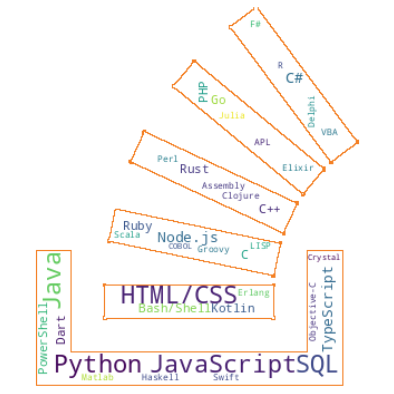

In [14]:
#https://amueller.github.io/word_cloud/auto_examples/parrot.html
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import numpy as np
from scipy.ndimage import gaussian_gradient_magnitude

df_lang = df_lang_worked.copy().reset_index()
df_lang['count'] = (df_lang['count'] * 10000).astype(int)

tuples = [tuple(x) for x in df_lang.values]
so_color = np.array(Image.open('so_logo2.png'))
# subsample by factor of 3. Very lossy but for a wordcloud we don't really care.
so_color = so_color[::3, ::3]

# create mask  white is "masked out"
so_mask = so_color.copy()
so_mask[so_mask.sum(axis=2) == 0] = 255

# some finesse: we enforce boundaries between colors so they get less washed out.
# For that we do some edge detection in the image
edges = np.mean([gaussian_gradient_magnitude(so_color[:, :, i] / 255., 2) for i in range(3)], axis=0)
so_mask[edges > .08] = 255

image_colors = ImageColorGenerator(so_color)
#wordcloud = WordCloud(background_color="#302d2b", mask=so_mask, contour_width=3, contour_color='firebrick').generate_from_frequencies(dict(tuples))
wordcloud = WordCloud(background_color="white", mask=so_mask, contour_width=1, contour_color='#f48024',
                    random_state=42, relative_scaling=0).generate_from_frequencies(dict(tuples))
plt.figure(figsize=[10,7])
#plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
wordcloud.to_file("wordcloud.png");

In [ ]:
#df_lang = df_lang_worked.copy().reset_index()
#df_lang = df_lang.reindex(columns=['count','value'])
#df_lang['count'] = (df_lang['count'] * 10000).astype(int)
#df_lang = df_lang.set_index('count')
#df_lang.to_csv('df_lang_worked.csv', header=False)

In [7]:
df_2021['Country'].value_counts()

United States of America                                15288
India                                                   10511
Germany                                                  5625
United Kingdom of Great Britain and Northern Ireland     4475
Canada                                                   3012
                                                        ...  
Liechtenstein                                               1
Brunei Darussalam                                           1
Saint Vincent and the Grenadines                            1
Tuvalu                                                      1
Dominica                                                    1
Name: Country, Length: 181, dtype: int64

In [8]:
df_us = df_2021[df_2021['Country']=='United States of America']
df_in = df_2021[df_2021['Country']=='India']
df_ge = df_2021[df_2021['Country']=='Germany']
df_uk = df_2021[df_2021['Country']=='United Kingdom of Great Britain and Northern Ireland']
df_ca = df_2021[df_2021['Country']=='Canada']
df_ru = df_2021[df_2021['Country']=='Russian Federation']
df_ch = df_2021[df_2021['Country']=='China']


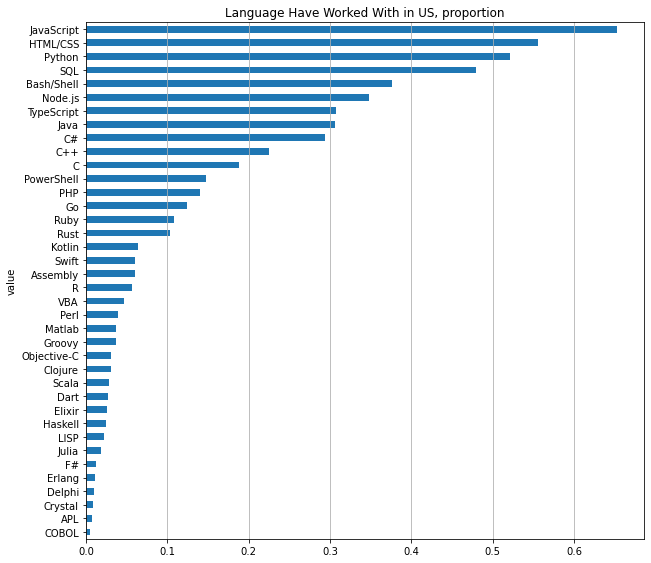

KeyboardInterrupt: 

In [9]:
df_lang_worked_us = clean_and_plot(df_us, col='LanguageHaveWorkedWith', col_suffix='_us', title='Language Have Worked With in US, proportion')
df_lang_worked_in = clean_and_plot(df_in, col='LanguageHaveWorkedWith', col_suffix='_in', title='Language Have Worked With in India, proportion')
df_lang_worked_ge = clean_and_plot(df_ge, col='LanguageHaveWorkedWith', col_suffix='_ge', title='Language Have Worked With in Germany, proportion')
df_lang_worked_uk = clean_and_plot(df_uk, col='LanguageHaveWorkedWith', col_suffix='_uk', title='Language Have Worked With in UK, proportion')
df_lang_worked_ca = clean_and_plot(df_ca, col='LanguageHaveWorkedWith', col_suffix='_ca', title='Language Have Worked With in Canada, proportion')
df_lang_worked_ru = clean_and_plot(df_ru, col='LanguageHaveWorkedWith', col_suffix='_ru', title='Language Have Worked With in Russia, proportion')
df_lang_worked_ch = clean_and_plot(df_ch, col='LanguageHaveWorkedWith', col_suffix='_ch', title='Language Have Worked With in China, proportion')


In [ ]:
df_lang_worked_joined = df_lang_worked_us.join(
    df_lang_worked_in).join(
    df_lang_worked_ge).join(
    df_lang_worked_uk).join(
    df_lang_worked_ca).join(
    df_lang_worked_ru).join(
    df_lang_worked_ch)
df_lang_worked_joined

,count_us,count_in,count_ge,count_uk,count_ca,count_ru,count_ch
value,,,,,,,
COBOL,0.005364,0.004567,0.002844,0.004469,0.005644,0.002714,0.005687
APL,0.007326,0.004091,0.004444,0.006034,0.006972,0.004749,0.011374
Crystal,0.008830,0.002283,0.004267,0.003799,0.004648,0.008141,0.002844
Delphi,0.009942,0.001998,0.029156,0.016536,0.014276,0.061058,0.012322
Erlang,0.010531,0.002854,0.006578,0.008045,0.006308,0.007463,0.009479
F#,0.012886,0.001427,0.009778,0.016089,0.008964,0.016282,0.008531
Julia,0.018446,0.007706,0.016711,0.011173,0.017264,0.005427,0.012322
LISP,0.022567,0.005518,0.013867,0.010726,0.015272,0.017639,0.018957
Haskell,0.024071,0.005899,0.035378,0.031732,0.016932,0.035278,0.019905


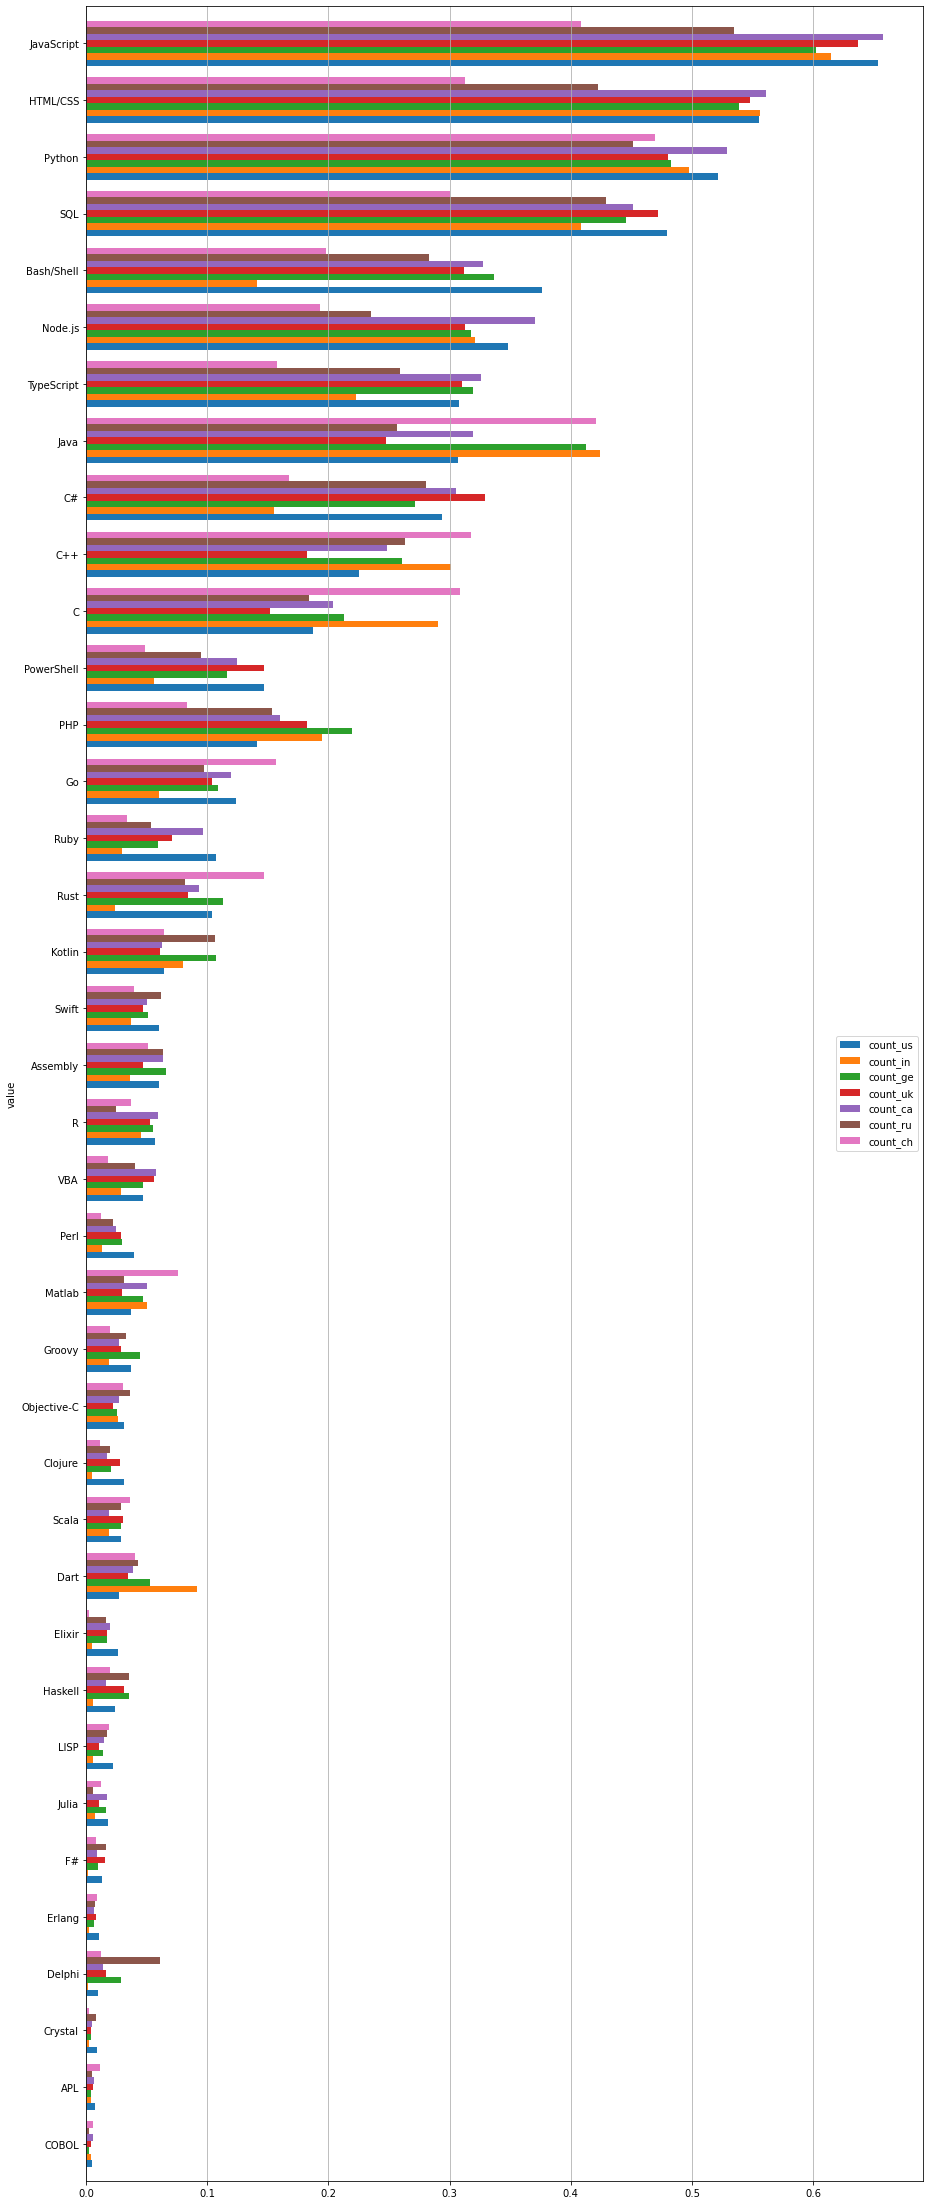

In [ ]:
df_lang_worked_joined.plot(kind='barh',figsize=(15,40), width=0.8).grid(axis='x');
plt.legend(loc='center right');

## Question 2: With what operating systems users worked in 2021?

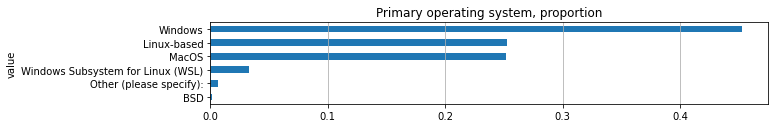

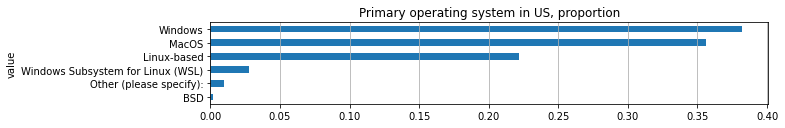

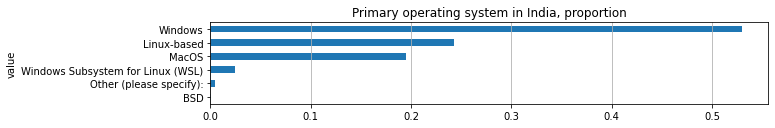

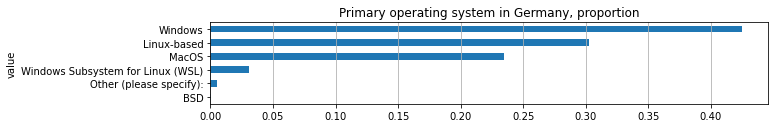

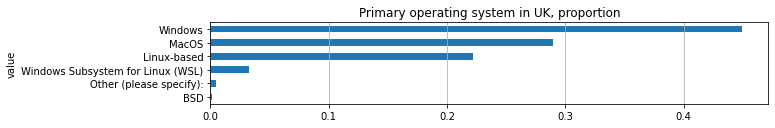

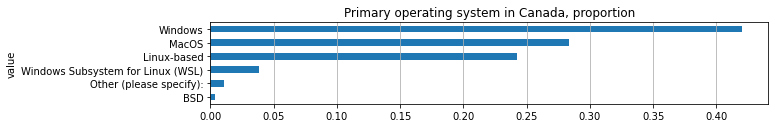

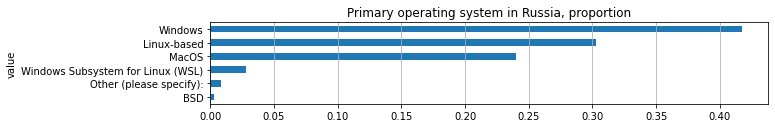

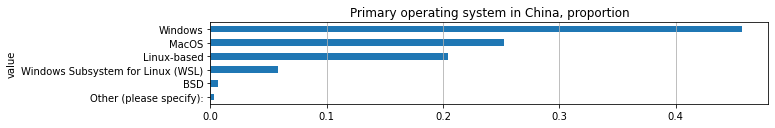

In [ ]:
df_OpSys = clean_and_plot(df_2021, col='OpSys', title='Primary operating system, proportion')

df_OpSys_us = clean_and_plot(df_us, col='OpSys', col_suffix='_us', title='Primary operating system in US, proportion')
df_OpSys_in = clean_and_plot(df_in, col='OpSys', col_suffix='_in', title='Primary operating system in India, proportion')
df_OpSys_ge = clean_and_plot(df_ge, col='OpSys', col_suffix='_ge', title='Primary operating system in Germany, proportion')
df_OpSys_uk = clean_and_plot(df_uk, col='OpSys', col_suffix='_uk', title='Primary operating system in UK, proportion')
df_OpSys_ca = clean_and_plot(df_ca, col='OpSys', col_suffix='_ca', title='Primary operating system in Canada, proportion')
df_OpSys_ru = clean_and_plot(df_ru, col='OpSys', col_suffix='_ru', title='Primary operating system in Russia, proportion')
df_OpSys_ch = clean_and_plot(df_ch, col='OpSys', col_suffix='_ch', title='Primary operating system in China, proportion')


In [ ]:
df_OpSys_joined = df_OpSys_us.join(
    df_OpSys_in).join(
    df_OpSys_ge).join(
    df_OpSys_uk).join(
    df_OpSys_ca).join(
    df_OpSys_ru).join(
    df_OpSys_ch)
df_OpSys_joined

,count_us,count_in,count_ge,count_uk,count_ca,count_ru,count_ch
value,,,,,,,
BSD,0.001832,0.000951,0.000711,0.001117,0.003652,0.002714,0.006635
Other (please specify):,0.009746,0.005042,0.005689,0.005140,0.010624,0.008141,0.002844
Windows Subsystem for Linux (WSL),0.027669,0.024165,0.031289,0.032626,0.038845,0.027815,0.057820
Linux-based,0.221415,0.242984,0.302756,0.221676,0.242364,0.302578,0.204739
MacOS,0.355965,0.194558,0.234667,0.289385,0.283201,0.240163,0.252133
Windows,0.381803,0.529731,0.424533,0.449162,0.419987,0.417232,0.456872


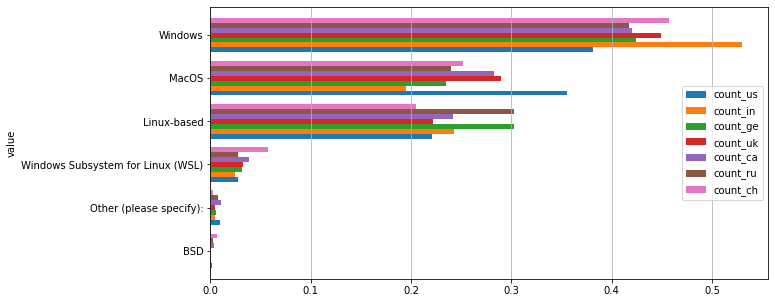

In [ ]:
df_OpSys_joined.plot(kind='barh',figsize=(10,5), width=0.8).grid(axis='x');
plt.legend(loc='center right');

## Question 3: What is the level of user's formal education?

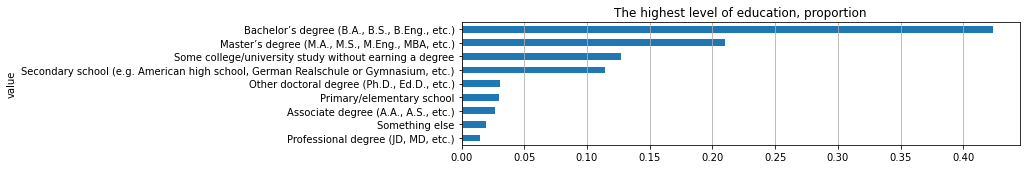

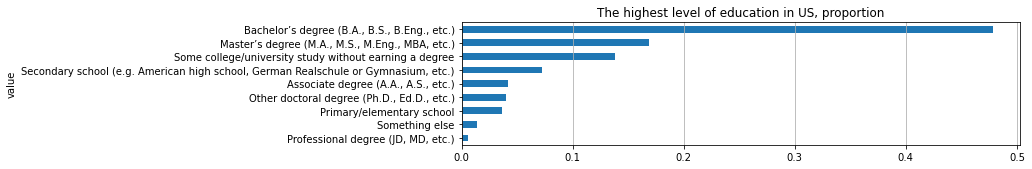

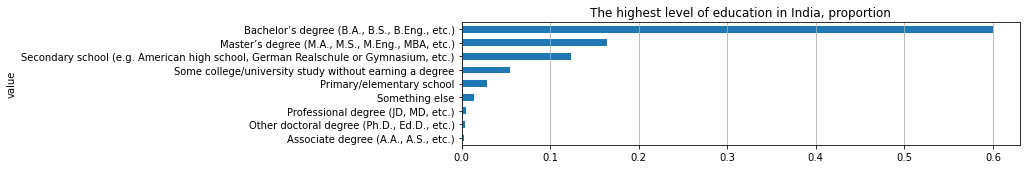

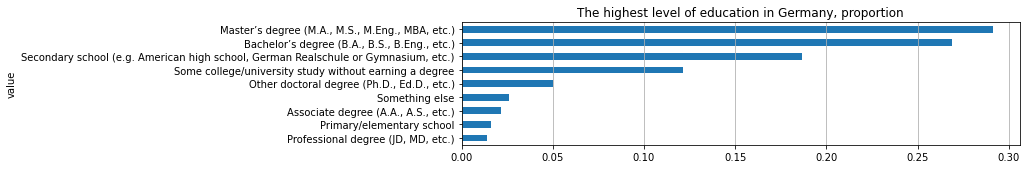

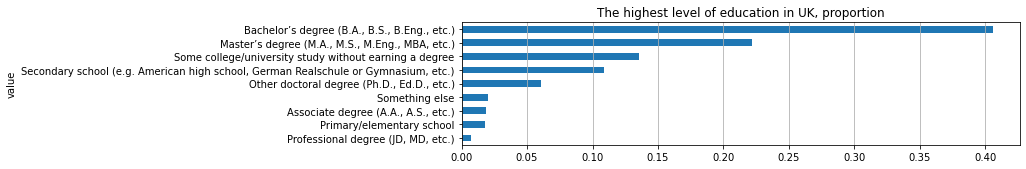

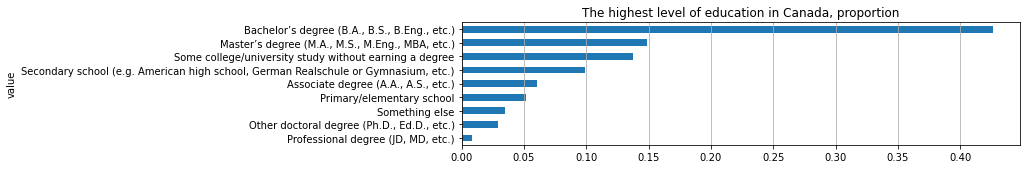

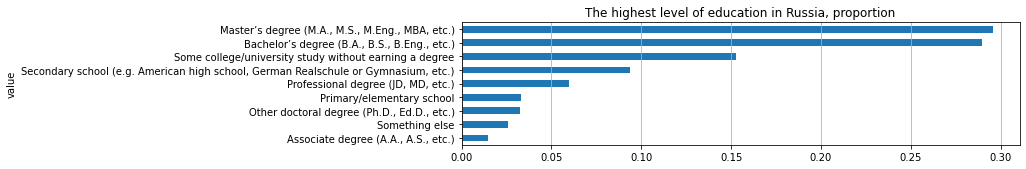

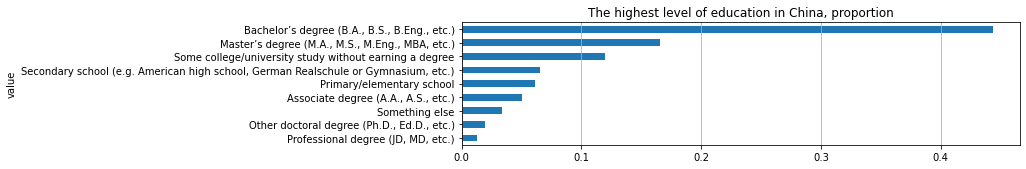

In [ ]:
df_EdLevel = clean_and_plot(df_2021, col='EdLevel', title='The highest level of education, proportion')

df_EdLevel_us = clean_and_plot(df_us, col='EdLevel', col_suffix='_us', title='The highest level of education in US, proportion')
df_EdLevel_in = clean_and_plot(df_in, col='EdLevel', col_suffix='_in', title='The highest level of education in India, proportion')
df_EdLevel_ge = clean_and_plot(df_ge, col='EdLevel', col_suffix='_ge', title='The highest level of education in Germany, proportion')
df_EdLevel_uk = clean_and_plot(df_uk, col='EdLevel', col_suffix='_uk', title='The highest level of education in UK, proportion')
df_EdLevel_ca = clean_and_plot(df_ca, col='EdLevel', col_suffix='_ca', title='The highest level of education in Canada, proportion')
df_EdLevel_ru = clean_and_plot(df_ru, col='EdLevel', col_suffix='_ru', title='The highest level of education in Russia, proportion')
df_EdLevel_ch = clean_and_plot(df_ch, col='EdLevel', col_suffix='_ch', title='The highest level of education in China, proportion')


In [ ]:
df_EdLevel_joined = df_EdLevel_us.join(
    df_EdLevel_in).join(
    df_EdLevel_ge).join(
    df_EdLevel_uk).join(
    df_EdLevel_ca).join(
    df_EdLevel_ru).join(
    df_EdLevel_ch)
df_EdLevel_joined

,count_us,count_in,count_ge,count_uk,count_ca,count_ru,count_ch
value,,,,,,,
"Professional degree (JD, MD, etc.)",0.006214,0.005423,0.014044,0.007374,0.008300,0.059701,0.013270
Something else,0.014129,0.013605,0.025778,0.019888,0.034529,0.025780,0.034123
Primary/elementary school,0.036041,0.028256,0.016178,0.018101,0.051461,0.033243,0.061611
"Other doctoral degree (Ph.D., Ed.D., etc.)",0.039704,0.003901,0.049956,0.060559,0.029548,0.032564,0.019905
"Associate degree (A.A., A.S., etc.)",0.041732,0.002474,0.021867,0.018771,0.060425,0.014925,0.050237
"Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",0.072410,0.123585,0.186489,0.108380,0.098938,0.093623,0.065403
Some college/university study without earning a degree,0.137886,0.054895,0.121600,0.135866,0.137782,0.152646,0.119431
"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",0.168629,0.163828,0.291378,0.221676,0.149070,0.295794,0.165877
"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",0.478480,0.600133,0.269156,0.405810,0.426295,0.289688,0.443602


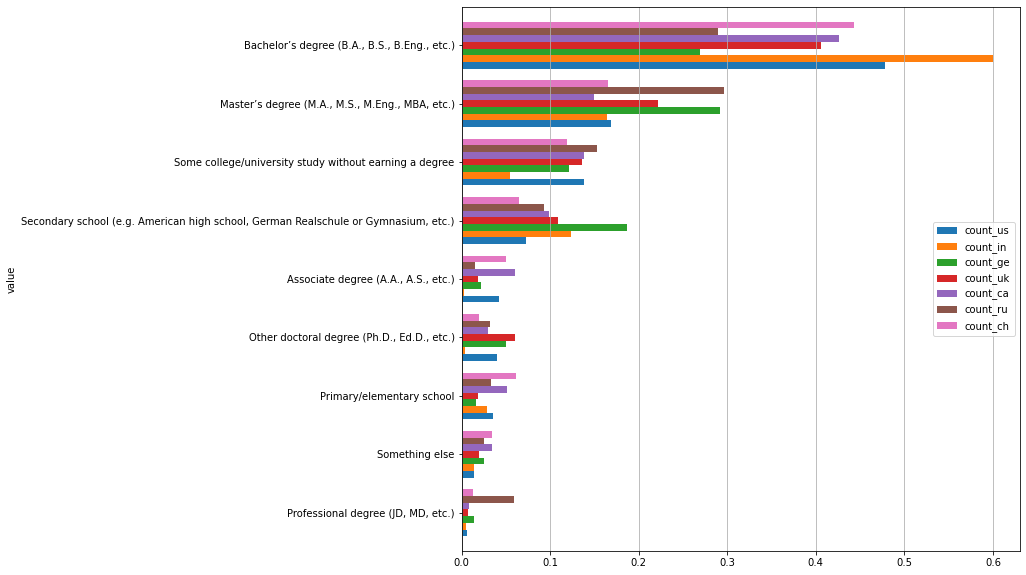

In [ ]:
df_EdLevel_joined.plot(kind='barh',figsize=(10,10), width=0.8).grid(axis='x');
plt.legend(loc='center right');

## Question 4: How well can we predict the SO Visit Frequency?

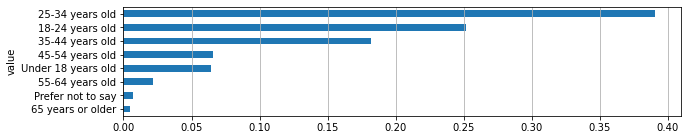

In [ ]:
df_Age = clean_and_plot(df_2021, col='Age')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


### Clean the data

In [ ]:
df_2021.shape

(83439, 48)

In [ ]:
def missing_vals(df):
    missing = {}
    for col in df.columns:
        prop_miss = round(df[col].isna().mean(),4)
        missing[col] = prop_miss
        print(f'{col}: {prop_miss}')
    return missing

In [ ]:
missing_dict = missing_vals(df_2021);

ResponseId: 0.0
MainBranch: 0.0
Employment: 0.0014
Country: 0.0
US_State: 0.8212
UK_Country: 0.9471
EdLevel: 0.0038
Age1stCode: 0.0023
LearnCode: 0.0057
YearsCode: 0.0215
YearsCodePro: 0.2663
DevType: 0.2032
OrgSize: 0.2722
Currency: 0.268
CompTotal: 0.4345
CompFreq: 0.375
LanguageHaveWorkedWith: 0.013
LanguageWantToWorkWith: 0.0793
DatabaseHaveWorkedWith: 0.1665
DatabaseWantToWorkWith: 0.3013
PlatformHaveWorkedWith: 0.3752
PlatformWantToWorkWith: 0.5012
WebframeHaveWorkedWith: 0.2605
WebframeWantToWorkWith: 0.3757
MiscTechHaveWorkedWith: 0.4361
MiscTechWantToWorkWith: 0.5443
ToolsTechHaveWorkedWith: 0.1307
ToolsTechWantToWorkWith: 0.2152
NEWCollabToolsHaveWorkedWith: 0.0264
NEWCollabToolsWantToWorkWith: 0.1248
OpSys: 0.0017
NEWStuck: 0.0046
NEWSOSites: 0.0032
SOVisitFreq: 0.0123
SOAccount: 0.011
SOPartFreq: 0.1904
SOComm: 0.0134
NEWOtherComms: 0.0073
Age: 0.0124
Gender: 0.0138
Trans: 0.0331
Sexuality: 0.1207
Ethnicity: 0.0476
Accessibility: 0.0699
MentalHealth: 0.0781
SurveyLength: 0.

In [ ]:
drop_target_na = df_2021.dropna(subset=['Age']) # drop rows with na in response variable (Age)
drop_target_na.shape

(82407, 48)

In [ ]:
# split on numeric and categorical

# List of categorical columns
cat_cols = [col for col in drop_target_na.columns if drop_target_na[col].dtype == "object"]
# List of numerical columns
num_cols = [col for col in drop_target_na.columns if drop_target_na[col].dtype != "object"]

print(f'categorical: {len(cat_cols)}\nnumerical: {len(num_cols)}')

categorical: 45
numerical: 3


#### Clean numerical data

In [ ]:
missing_vals(drop_target_na[num_cols]);

ResponseId: 0.0
CompTotal: 0.4288
ConvertedCompYearly: 0.4329


In [ ]:
fill_mean = lambda col: col.fillna(col.median()) if (col.name in num_cols) else col 

fill_num_na = drop_target_na.apply(fill_mean, axis=0) #Fill all missing values with the mean of the column.
missing_vals(fill_num_na[num_cols]);

ResponseId: 0.0
CompTotal: 0.0
ConvertedCompYearly: 0.0


In [ ]:
fill_num_na[fill_num_na['CompTotal']>10**18][num_cols]

,ResponseId,CompTotal,ConvertedCompYearly
103,104,1.000000e+29,56211.0
6378,6379,1.000000e+74,56211.0
18919,18920,8.000000e+52,56211.0
62417,62418,7.000000e+39,56211.0


In [ ]:
print(fill_num_na.shape)
fill_num_na = fill_num_na.drop(fill_num_na[fill_num_na['CompTotal']>10**18].index)
print(fill_num_na.shape)


(82407, 48)
(82403, 48)


#### Clean categorical data

In [ ]:
cat_cols2 = cat_cols.copy()
cat_cols2.remove('Age')

#num_df = fill_num_na.drop(cat_cols2, axis=1)
cat_cols2

['MainBranch',
 'Employment',
 'Country',
 'US_State',
 'UK_Country',
 'EdLevel',
 'Age1stCode',
 'LearnCode',
 'YearsCode',
 'YearsCodePro',
 'DevType',
 'OrgSize',
 'Currency',
 'CompFreq',
 'LanguageHaveWorkedWith',
 'LanguageWantToWorkWith',
 'DatabaseHaveWorkedWith',
 'DatabaseWantToWorkWith',
 'PlatformHaveWorkedWith',
 'PlatformWantToWorkWith',
 'WebframeHaveWorkedWith',
 'WebframeWantToWorkWith',
 'MiscTechHaveWorkedWith',
 'MiscTechWantToWorkWith',
 'ToolsTechHaveWorkedWith',
 'ToolsTechWantToWorkWith',
 'NEWCollabToolsHaveWorkedWith',
 'NEWCollabToolsWantToWorkWith',
 'OpSys',
 'NEWStuck',
 'NEWSOSites',
 'SOVisitFreq',
 'SOAccount',
 'SOPartFreq',
 'SOComm',
 'NEWOtherComms',
 'Gender',
 'Trans',
 'Sexuality',
 'Ethnicity',
 'Accessibility',
 'MentalHealth',
 'SurveyLength',
 'SurveyEase']

In [ ]:
fill_num_na[(fill_num_na['Country']!='United States of America') & fill_num_na['US_State'].notna()]

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly


In [ ]:
fill_num_na.loc[fill_num_na['Country']=='United States of America', 'Country'] = 'US/'+fill_num_na['US_State']
fill_num_na = fill_num_na.drop('US_State', axis=1)
cat_cols2.remove('US_State')
fill_num_na.shape

(82403, 47)

In [ ]:
fill_num_na[(fill_num_na['Country']!='United Kingdom of Great Britain and Northern Ireland') & fill_num_na['UK_Country'].notna()]

,ResponseId,MainBranch,Employment,Country,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,YearsCodePro,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly


In [ ]:
fill_num_na.loc[fill_num_na['Country']=='United Kingdom of Great Britain and Northern Ireland', 'Country'] = 'UK/'+fill_num_na['UK_Country']
fill_num_na = fill_num_na.drop('UK_Country', axis=1)
cat_cols2.remove('UK_Country')
fill_num_na.shape

(82403, 46)

In [ ]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    
    for col in cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue

    return df

In [ ]:
dont_use = ['LearnCode','DevType',
            'LanguageHaveWorkedWith','LanguageWantToWorkWith',
            'DatabaseHaveWorkedWith','DatabaseWantToWorkWith',
            'PlatformHaveWorkedWith','PlatformWantToWorkWith',
            'WebframeHaveWorkedWith','WebframeWantToWorkWith',
            'MiscTechHaveWorkedWith','MiscTechWantToWorkWith',
            'ToolsTechHaveWorkedWith','ToolsTechWantToWorkWith',
            'NEWCollabToolsHaveWorkedWith','NEWCollabToolsWantToWorkWith',
            'NEWStuck','NEWSOSites', 'Ethnicity', 'Accessibility', 'Sexuality', 'Gender', 'MentalHealth']
cat_features = list(set(cat_cols2)-set(dont_use))
num_cat_df = fill_num_na.drop(dont_use, axis=1)
print(num_cat_df.shape)
print(num_cat_df.columns)

(82403, 23)
Index(['ResponseId', 'MainBranch', 'Employment', 'Country', 'EdLevel',
       'Age1stCode', 'YearsCode', 'YearsCodePro', 'OrgSize', 'Currency',
       'CompTotal', 'CompFreq', 'OpSys', 'SOVisitFreq', 'SOAccount',
       'SOPartFreq', 'SOComm', 'NEWOtherComms', 'Age', 'Trans', 'SurveyLength',
       'SurveyEase', 'ConvertedCompYearly'],
      dtype='object')


In [ ]:
#Split into explanatory and response variables
X = num_cat_df.drop(['Age','ResponseId'], axis=1)
y = num_cat_df['Age']

X.shape

(82403, 21)

In [ ]:
X = create_dummy_df(X, cat_features, dummy_na=True)


In [ ]:
X.shape

(82403, 572)

In [ ]:
# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)


In [ ]:
rf = RandomForestClassifier(random_state = 1)
rf.fit(X_train, y_train)

cv = cross_val_score(rf,X_train,y_train,cv=5)
print(f'{cv} => mean = {cv.mean()}')


[0.72566525 0.72289157 0.72910888 0.73474341 0.72850208] => mean = 0.7281822372257768


**['ResponseId','CompTotal','ConvertedCompYearly']**
- [0.2658173  0.26315333 0.27303458 0.26852735 0.26835399] => mean = **0.26777731095953267**
- [0.30351881 0.30328508 0.30068475 0.30649216 0.3020716 ] => mean = **0.3032104790013449**

**['CompTotal','ConvertedCompYearly']**
- [0.2951118  0.30415186 0.29747768 0.29531074 0.29149692] => mean = **0.29670980130355423**
- [0.28141792 0.29635087 0.28369593 0.30718558 0.30666551] => mean = **0.29506316342336164**

**['MainBranch','CompTotal','ConvertedCompYearly']**
- [0.30169873 0.31307966 0.30640548 0.30926584 0.29834446] => mean = **0.3057588333408231**
- [0.2817646  0.3063188  0.28334922 0.30718558 0.30666551] => mean = **0.2970567432676793**

**['MainBranch','Employment','CompTotal','ConvertedCompYearly']**
- [0.29857861 0.30909249 0.3039785  0.30571206 0.30120482] => mean = **0.30371329498812843**
- [0.28150459 0.3063188  0.28326255 0.30675219 0.30666551] => mean = **0.296900728012594**

**['MainBranch','Employment','Country','CompTotal','ConvertedCompYearly']**
- [0.28427804 0.29193031 0.28742307 0.28794314 0.28568952] => mean = **0.28745281653743976**
- [0.28141792 0.29583081 0.28317587 0.30675219 0.30666551] => mean = **0.2947684594275222**

**+EdLevel**
- [0.27855781 0.28022883 0.28178903 0.27728179 0.27936205] => mean = **0.27944390122546625**
- [0.28141792 0.29583081 0.28317587 0.30675219 0.30666551] => mean = **0.2947684594275222**

**All except: ['LearnCode','DevType',
            'LanguageHaveWorkedWith','LanguageWantToWorkWith',
            'DatabaseHaveWorkedWith','DatabaseWantToWorkWith',
            'PlatformHaveWorkedWith','PlatformWantToWorkWith',
            'WebframeHaveWorkedWith','WebframeWantToWorkWith',
            'MiscTechHaveWorkedWith','MiscTechWantToWorkWith',
            'ToolsTechHaveWorkedWith','ToolsTechWantToWorkWith',
            'NEWCollabToolsHaveWorkedWith','NEWCollabToolsWantToWorkWith',
            'NEWStuck','NEWSOSites']**
- [0.35309412 0.35615845 0.34601716 0.35139118 0.35693855] => mean = **0.35271989088803385**
- [0.28150459 0.29799775 0.28317587 0.30675219 0.30666551] => mean = **0.29521918168339234**



- [0.71673745 0.71838433 0.72286755 0.72850208 0.72884882] => mean = **0.7230680457388681**

In [ ]:
# Make predictions for the test set
y_pred_test = rf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

# View accuracy score
accuracy_score(y_test, y_pred_test)


0.7282876906274018

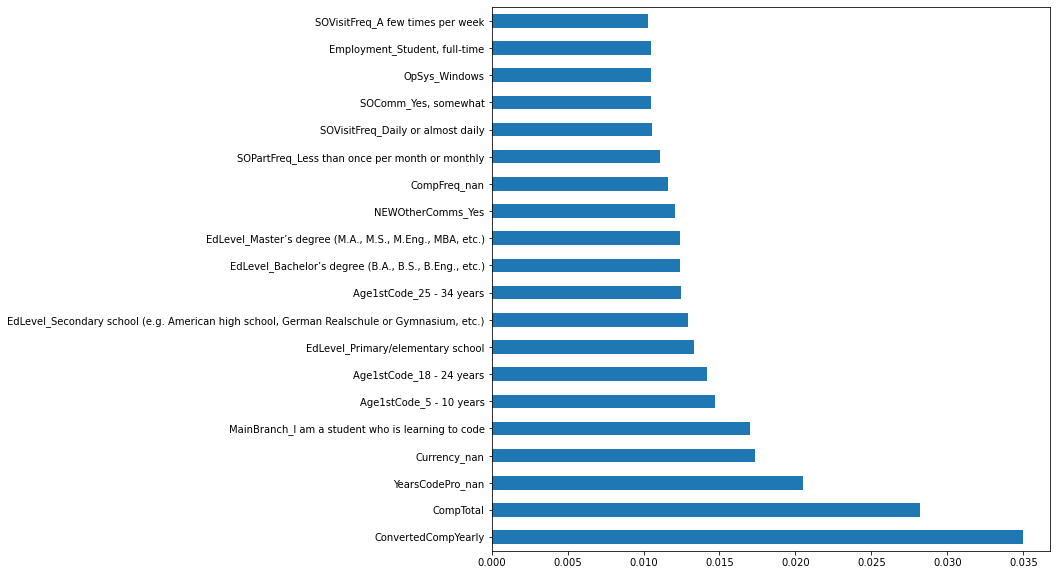

In [ ]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

forest_importances.nlargest(20).plot(kind='barh', figsize=(10,0.25*40)); #len(forest_importances)


/usr/lib/python3/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lib/python3/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


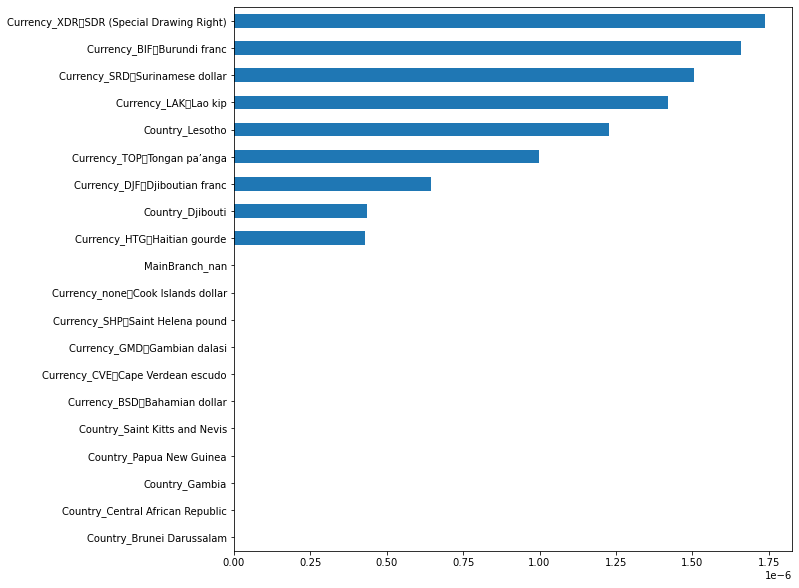

In [ ]:
forest_importances.nsmallest(20).plot(kind='barh', figsize=(10,0.25*40)); #len(forest_importances)


In [ ]:
fill_num_na['LearnCode'].head()

0    Coding Bootcamp;Other online resources (ex: vi...
1    Other online resources (ex: videos, blogs, etc...
2    Other online resources (ex: videos, blogs, etc...
3                                                  NaN
4                              Friend or family member
Name: LearnCode, dtype: object

In [ ]:
fill_num_na['LearnCode'].str.get_dummies(sep=';')

,Books / Physical media,Coding Bootcamp,Colleague,Friend or family member,Online Courses or Certification,Online Forum,Other (please specify):,"Other online resources (ex: videos, blogs, etc)",School
0,0,1,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
83434,0,0,0,0,0,1,0,1,1
83435,1,0,0,0,1,1,0,1,1
83436,0,0,0,0,0,0,0,0,1
83437,1,0,0,0,1,0,0,0,0


In [ ]:
for col in dont_use:
    X = pd.concat([X, fill_num_na[col].str.get_dummies(sep=';')], axis=1)
X.shape

(82403, 909)

In [ ]:
# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)


In [ ]:
rf = RandomForestClassifier(random_state = 1)
rf.fit(X_train, y_train)

cv = cross_val_score(rf,X_train,y_train,cv=5)
print(f'{cv} => mean = {cv.mean()}')


[0.69844847 0.70052873 0.70353675 0.70145631 0.70752427] => mean = 0.7022989081622091


In [ ]:
# Make predictions for the test set
y_pred_test = rf.predict(X_test)

In [ ]:
# View accuracy score
accuracy_score(y_test, y_pred_test)


0.7050685651874924

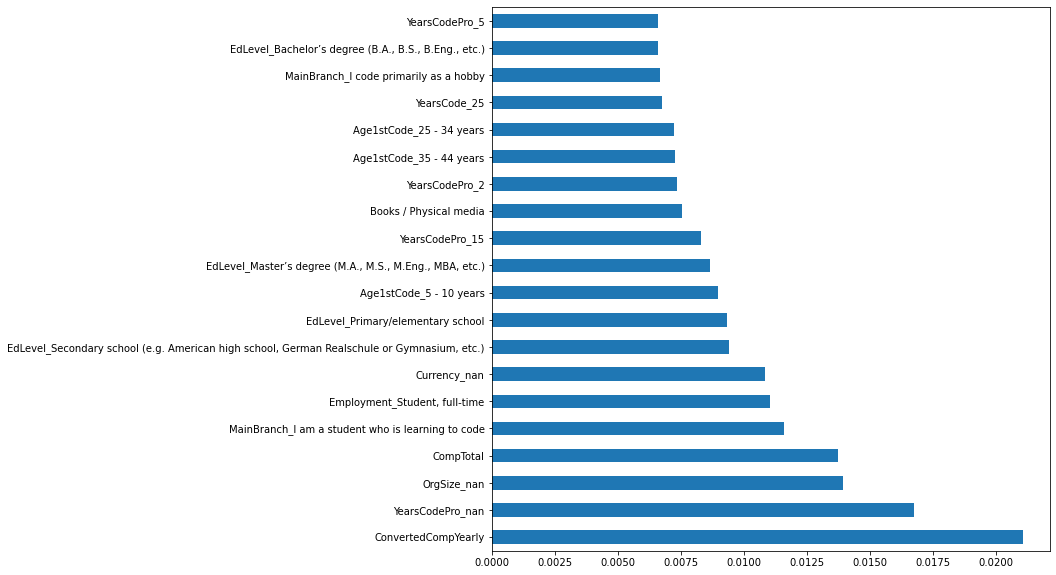

In [ ]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

forest_importances.nlargest(20).plot(kind='barh', figsize=(10,0.25*40)); #len(forest_importances)
